## Learned Reconstruction

This notebook demonstrates how to use ODL to perform learned reconstruction of the famous MNIST dataset.

We demonstrate three ways of doing this

* Fully learned reconstruction
* Learned post-processing
* Learned Primal-Dual reconstruction

and we also compare to a simple FBP-based reconstruction, the results should be approximately

| Method                 |   Error  |
|:-----------------------|:--------:|
| FBP                    | 0.1510   |
| Fully learned          | 0.0240   |
| FBP + learned denoiser | 0.0197   |
| Learned Primal-Dual    | 0.0151   |



# Import dependencies

This should run without errors if all dependencies are installed properly.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import odl
import odl.contrib.tensorflow
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import display, clear_output

/home/olivierv/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [19]:
# Start a tensorflow session
session = tf.InteractiveSession()

# Set the random seed to enable reproducible code
np.random.seed(0)

# Create operators using ODL

Here we create the needed operators in ODL as usual, we then convert them to tensorflow-compatible functions using the `odl.contrib.tensorflow.as_tensorflow_layer` function.

In [3]:
# Create ODL data structures
space = odl.uniform_discr([-14, -14], [14, 14], [28, 28],
                          dtype='float32')

geometry = odl.tomo.parallel_beam_geometry(space, num_angles=5)
operator = odl.tomo.RayTransform(space, geometry)
fbp_op = odl.tomo.fbp_op(operator)

# Create tensorflow wrappers
tf_op = odl.contrib.tensorflow.as_tensorflow_layer(operator)
tf_op_adj = odl.contrib.tensorflow.as_tensorflow_layer(operator.adjoint)
tf_fbp_op = odl.contrib.tensorflow.as_tensorflow_layer(fbp_op)

# Get data and utilities

We now need to get the data we will use, which in this case is the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, a set of digits 70000 hand-written digits, of which 60000 are used for training and 10000 for testing.

In addition to this, we create a utility `generate_data` which generates sinograms for each digit, as well as a function `evaluate(...)` that we will use to evaluate how good a reconstruction is and `visualize(...)` which shows an example reconstruction.

In [4]:
# Get MNIST data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
def generate_data(images):
    """Generate data from images
    
    Parameters
    ----------
    images : np.array of shape [Batch, 28, 28, 1]
        The images (in reconstruction space) which we should create data for.
        
    Returns
    -------
    sinograms : np.array of shape [Batch, 5, 41, 1]
        Noisy sinograms corresponding to ``images``
    """
    data = [operator(image.squeeze()).asarray() +
            np.random.randn(*operator.range.shape) for image in images]
    return np.array(data)[..., None]

In [6]:
# Read the first 1000 mnist test points
batch = mnist.test.next_batch(1000)
test_images = batch[0].reshape([-1, 28, 28, 1])

# Create test data (persistent to save time)
test_images = test_images
test_data = generate_data(test_images)

def evaluate(result_tensor, data_placeholder):
    """Evaluate a reconstruction method.

    Parameters
    ----------
    result_tensor : `tf.Tensor`, shape (None, 28, 28, 1)
        The tensorflow tensor containing the result of the reonstruction
        operator.
    data_placeholder : `tf.Tensor`, shape (None, 5, 41, 1)
        The tensorflow tensor containing the input to the reconstruction
        operator.

    Returns
    -------
    MSE : float
        Mean squared error of the reconstruction.
    """
    result = result_tensor.eval(
        feed_dict={data_placeholder: test_data})

    return np.mean((result - test_images) ** 2)

In [20]:
def display_progress(i, max_iter, result_tensor, data_placeholder, every=100):
    """
    Utility function to display training progress.
    """
    if i % every == 0:
        error = evaluate(result_tensor, data_placeholder)
        clear_output()
        display('{}/{} Error: {:.5f}'.format(i,max_iter, error))

In [8]:
def visualize(result_tensor, data_placeholder, indices=None):
    """Visualize the result of a reconstruction.
    
    Parameters
    ----------
    result_tensor : `tf.Tensor`, shape (None, 28, 28, 1)
        The tensorflow tensor containing the result of the reonstruction
        operator.
    data_placeholder : `tf.Tensor`, shape (None, 5, 41, 1)
        The tensorflow tensor containing the input to the reconstruction
        operator.
    """
    if indices is None:
        indices = [0]
        
    result = result_tensor.eval(
        feed_dict={data_placeholder: test_data[indices]})
    
    size = 2
    fig, rows = plt.subplots(len(indices), 2, sharex=True, sharey=True, figsize=(2*size, size*len(indices)))
    # stupid matplotlib:
    if len(indices) == 1:
        rows = [rows]
    for i, (img, res, ax) in enumerate(zip(test_images[indices], result, rows)):
        if i == 0:
            ax[0].set_title('truth')
            ax[1].set_title('reconstruction')
        ax[0].imshow(img.squeeze(), clim=[0, 1], cmap='bone')
        ax[0].set_axis_off()
        ax[1].imshow(res.squeeze(), clim=[0, 1], cmap='bone')
        ax[1].set_axis_off()
    plt.show()

In [9]:
rand_indices = np.random.randint(low=0, high=len(test_data), size=8)

In [10]:
# Create placeholders. Placeholders are needed in tensorflow since tensorflow is a lazy language,
# and hence we first define the computational graph with placeholders as input, and later we evaluate it.
with tf.name_scope('placeholders'):
    x_true = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name="x_true")
    y = tf.placeholder(tf.float32, shape=[None, *operator.range.shape, 1], name="y")

FBP Mean squared error: 0.15122871100902557


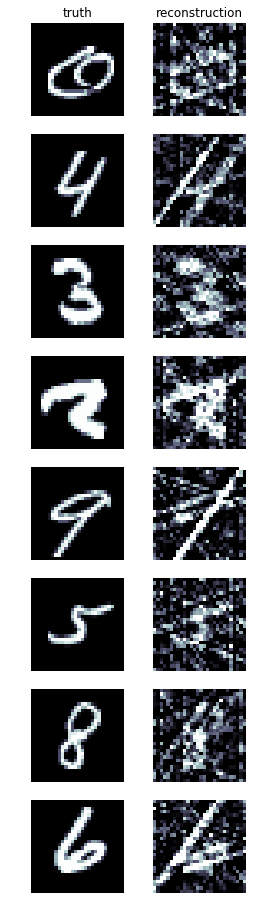

In [11]:
# Use the evaluator on the FBP reconstruction as a baseline
print('FBP Mean squared error: {}'.format(evaluate(tf_fbp_op(y), y)))
visualize(tf_fbp_op(y), y, indices=rand_indices)

# Fully Learned Reconstruction

The most straight-forward example of a learned reconstruction method is the fully-learned reconstruction. In this method, we use a fully-connected neural network to map data to reconstruction, using no information about the forward operator.

In [21]:
with tf.name_scope('fully_learned_reconstruction'):
    x = tf.contrib.layers.flatten(y)

    x = tf.contrib.layers.fully_connected(x, num_outputs=1024)
    x = tf.contrib.layers.fully_connected(x, num_outputs=1024)
    x = tf.contrib.layers.fully_connected(x, num_outputs=28 * 28,
                                          activation_fn=None)

    x_result_fully = tf.reshape(x, [-1, 28, 28, 1])

with tf.name_scope('optimizer'):
    loss = tf.reduce_mean((x_result_fully - x_true) ** 2)
    optimizer = tf.train.AdamOptimizer().minimize(loss)

# Initialize all TF variables
session.run(tf.global_variables_initializer())

max_iter = 10000
for i in range(max_iter):
    batch = mnist.train.next_batch(5)
    images = batch[0].reshape([-1, 28, 28, 1])
    data = generate_data(images)

    session.run(optimizer, feed_dict={x_true: images, y: data})
    
    display_progress(i, max_iter, x_result_fully, y)

'9900/10000 Error: 0.02479'

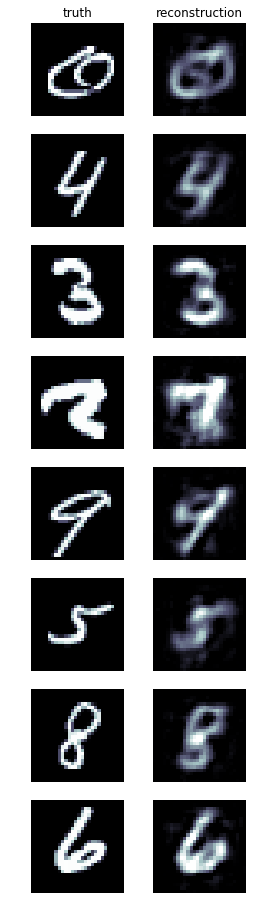

In [22]:
visualize(x_result_fully, y, rand_indices)

# FBP + Learned denoiser

A more efficient method is to first compute some initial reconstruction (here, a filtered back-projection) and then learn how to improve that reconstruction. By doing this, we only need to learn in image space and can thus use very strong tools from machine learning, including convolutional neural networks.

In [23]:
with tf.name_scope('learned_denoiser'):
    x = tf_fbp_op(y)

    x = tf.contrib.layers.conv2d(x, num_outputs=32, kernel_size=3)
    x = tf.contrib.layers.conv2d(x, num_outputs=32, kernel_size=3)
    x = tf.contrib.layers.conv2d(x, num_outputs=1, kernel_size=1,
                                 activation_fn=None)

    x_result_denoise = x

with tf.name_scope('optimizer'):
    loss = tf.reduce_mean((x_result_denoise - x_true) ** 2)
    optimizer = tf.train.AdamOptimizer().minimize(loss)

# Initialize all TF variables
session.run(tf.global_variables_initializer())

max_iter = 10000
for i in range(10000):
    batch = mnist.train.next_batch(5)
    images = batch[0].reshape([-1, 28, 28, 1])
    data = generate_data(images)

    session.run(optimizer, feed_dict={x_true: images, y: data})

    display_progress(i, max_iter, x_result_denoise, y, 500)

'9500/10000 Error: 0.01956'

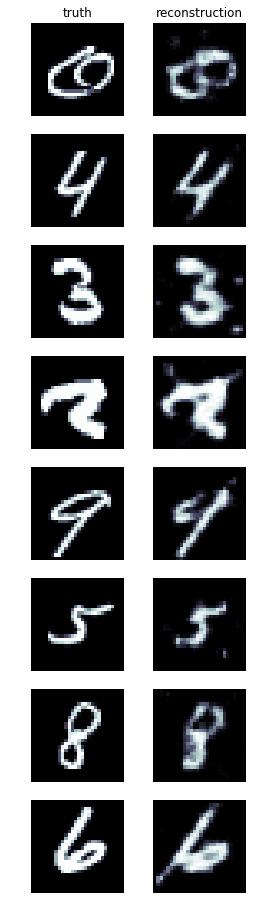

In [24]:
visualize(x_result_denoise, y, rand_indices)

# Learned Primal-Dual

In Learned Primal-Dual reconstruction, we embed the forward operator into a neural network and use it as a component in the neural network. By doing so, we can learn in both reconstruction and in data space, and we can use convolutional networks in both of them.

In [25]:
with tf.name_scope('learned_primal_dual'):
    primal = tf_fbp_op(y)
    dual = tf.identity(y)
    
    for i in range(1):
        dy = tf.concat([dual, tf_op(primal)], axis=-1)
        dy = tf.contrib.layers.conv2d(dy, num_outputs=32, kernel_size=3)
        dy = tf.contrib.layers.conv2d(dy, num_outputs=1, kernel_size=3,
                                      activation_fn=None)
        dual = dual + dy

        dx = tf.concat([primal, tf_op_adj(dual)], axis=-1)
        dx = tf.contrib.layers.conv2d(dx, num_outputs=32, kernel_size=3)
        dx = tf.contrib.layers.conv2d(dx, num_outputs=1, kernel_size=3,
                                      activation_fn=None)
        primal = primal + dx
    
    x_result_lpd = primal

with tf.name_scope('optimizer'):
    loss = tf.reduce_mean((x_result_lpd - x_true) ** 2)
    optimizer = tf.train.AdamOptimizer().minimize(loss)

# Initialize all TF variables
session.run(tf.global_variables_initializer())

max_iter = 10000
for i in range(max_iter):
    batch = mnist.train.next_batch(5)
    images = batch[0].reshape([-1, 28, 28, 1])
    data = generate_data(images)

    session.run(optimizer, feed_dict={x_true: images, y: data})

    display_progress(i, max_iter, x_result_lpd, y, 200)

'9800/10000 Error: 0.01562'

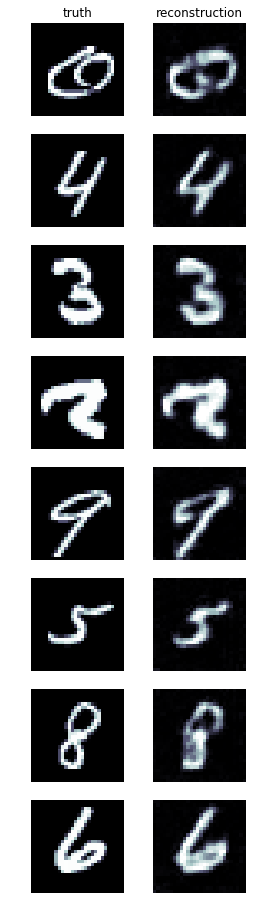

In [26]:
visualize(x_result_lpd, y, rand_indices)